In [68]:
pip install colour

Note: you may need to restart the kernel to use updated packages.


In [69]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm
import numpy as np
import pandas as pd
import plotly.express as px
import os
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import LinearLocator
from PIL import Image
from scipy import stats
from sklearn import tree
from tqdm import tqdm
from colour import Color

csfont = {'fontname':'Times New Roman'}
hfont = {'fontname':'Helvetica'}
prop = fm.FontProperties(fname='/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf')
import matplotlib as mpl  
mpl.rc('font',family='Times New Roman')

In [70]:
td_dataset = pd.read_stata("data/td_ita.dta")  # time diaries dataset
demo_dataset = pd.read_stata("data/data4diarynew_ITA.dta") # demographics dataset
step_dataset = pd.read_csv("data/stepDetector_30min.csv") # step counter dataset
sport_eve = pd.read_csv("data/sport_eventformat.csv")

/tmp/ipykernel_972213/41779431.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  sport_eve = pd.read_csv("data/sport_eventformat.csv")


In [71]:
sport_eve.date_not = pd.to_datetime(sport_eve.date_not.copy())
results = sport_eve
results['hour'] = (results['date_not'].dt.hour - 5) + results['date_not'].dt.minute/60

In [72]:
1433 / 2600

0.5511538461538461

In [73]:
# Building a way to check from code what weekday it was and storing weekends 
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = weekdays[i]

#list of weekend days in calendar time
weekend_clock_days = [14, 15, 21, 22, 28]

for day in weekend_clock_days:
    weekday = weekdays[sport_eve[sport_eve.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")


The date 14 was a Sat
The date 15 was a Sun
The date 21 was a Sat
The date 22 was a Sun
The date 28 was a Sat


In [74]:
print(f"N of users: {sport_eve.id.unique().shape[0]}")

N of users: 128


# Breaking down by eventually smaller and smaller time units. 
This section is meant to explore different possibilities when it comes to breaking down data by time. As one time unit could be hiding patterns that are not present in another time unit, the purpose of this section is to visualize patterns and oddities.

## By hour (all days in one), sport sessions. All 128 users.

In [75]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demo = demo_dataset[[ 'userid', 'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN', 'w1_A10UNITN']]

def which_day(t):
    return weekdays[t.weekday()]

def order_days(i):
    if i == 'Mon':
        return 0
    elif i == 'Tue':
        return 1
    elif i == 'Wed':
        return 2
    elif i == 'Thu':
        return 3
    elif i == 'Fri':
        return 4
    elif i == 'Sat':
        return 5
    elif i == 'Sun':
        return 6
    
    
results['weekday'] = results.date_not.apply(which_day)

csfont = {'fontname':'Times New Roman'}
hfont = {'fontname':'Helvetica'}

g = results
demo.loc[:,'userid'] = demo.userid.astype(int)
merged_df = g.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates().drop(columns="userid")
merged_df['id'] = merged_df['id'].astype(int)

merged_df['order'] = [order_days(i) for i in merged_df['weekday']]
merged_df = merged_df.sort_values(by='order')
sport_data = merged_df[merged_df['what'] == 'Sport']

F = demo.w1_A01.value_counts().iloc[0]
M = demo.w1_A01.value_counts().iloc[1]
N = F + M 
print(f'Generally speaking, if no had participants dropped out, the Female to Male ratio in the dataset would be:  {F}/{M} = {F/M:.2f}') 

F = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts().iloc[0]
M = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts().iloc[1]
print(f'Now, between the people who practiced sport at least once and had consistent data, the same ratio is: {F}/{M} = {F/M}')

Generally speaking, if no had participants dropped out, the Female to Male ratio in the dataset would be:  142/107 = 1.33
Now, between the people who practiced sport at least once and had consistent data, the same ratio is: 70/56 = 1.25


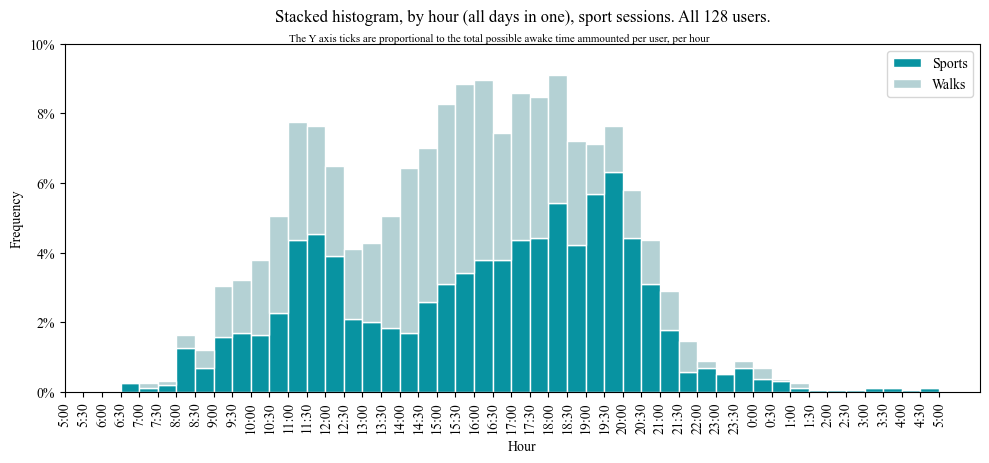

In [76]:
g = results.copy()

def today_or_yesterday(t): 
    '''
    Context: every hour is subtracted 5, to make 05:00 equal to 0. Every hour before that
    becomes negative, and so this function moves it onto the end of the distribution, to signify it's another 
    day.
    '''
    
    if t < 0:
        return t + 24
    else:
        return t
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)

custom_order = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30', 
                '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', 
                '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', 
                '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', 
                '21:00', '21:30','22:00', '23:00', '23:30', '0:00', '0:30', '1:00', '1:30', 
                '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00']
n_of_bins = g[(g.what == 'Sport') | (g.what == 'Walking') ].hour.unique().shape[0]
ax.hist([g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"]],
        bins = n_of_bins-1,
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#0893a1", "#b4d1d4"), 
       )

N = g[g['hour'] == 0].shape[0] * (24 - 7.5)/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))

ax.set_xticks(np.arange(len(custom_order))/2)
ax.set_xticklabels(custom_order, rotation=90)


plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0.0, 0.1*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 
ax.yaxis.set_major_locator(plt.LinearLocator(6))

#THIS_DAY = weekdays[g.date_not.head(1).dt.dayofweek.values[0]]
plt.title(f'Stacked histogram, by hour (all days in one), sport sessions. All {g.id.unique().shape[0]} users.', y=1.04)
plt.suptitle("   The Y axis ticks are proportional to the total possible awake time ammounted per user, per hour", y=0.87, ha='center', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig('byhour_everyday.jpg', dpi=300)

plt.show()

In [77]:
g[(g.what == 'Sport') | (g.what == 'Walking') ]

,Unnamed: 0,date_not,pilot,id,datein_ques,datein_answ,first2w,week,YY_not,MM_not,...,c6_21,c6_22,c6_23,c6_24,c6_25,c6_26,day,date_dur,hour,weekday
522,522,2020-11-15 10:30:00,wenetItaly,0,2020-11-15 11:41:23,2020-11-15 11:42:53,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15,2020-11-15 05:30:00,5.5,Sun
523,523,2020-11-15 11:00:00,wenetItaly,0,2020-11-15 11:41:23,2020-11-15 11:43:03,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15,2020-11-15 06:00:00,6.0,Sun
524,524,2020-11-15 13:30:00,wenetItaly,0,2020-11-15 15:04:33,2020-11-15 15:08:10,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15,2020-11-15 08:30:00,8.5,Sun
525,525,2020-11-15 13:00:00,wenetItaly,0,2020-11-15 15:04:33,2020-11-15 15:07:56,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,15,2020-11-15 08:00:00,8.0,Sun
526,526,2020-11-26 16:30:00,wenetItaly,0,2020-11-26 17:40:19,2020-11-26 17:41:09,First two weeks,Thursday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,26,2020-11-26 11:30:00,11.5,Thu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109182,109182,2020-11-17 11:00:00,wenetItaly,265,2020-11-17 10:59:59,2020-11-17 11:03:13,First two weeks,Tuesday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17,2020-11-17 06:00:00,6.0,Tue
109183,109183,2020-11-22 16:30:00,wenetItaly,265,2020-11-22 16:30:00,2020-11-22 18:32:08,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22,2020-11-22 11:30:00,11.5,Sun
109184,109184,2020-11-22 16:00:00,wenetItaly,265,2020-11-22 15:59:59,2020-11-22 18:31:49,First two weeks,Sunday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,22,2020-11-22 11:00:00,11.0,Sun
110443,110443,2020-11-17 08:30:00,wenetItaly,266,2020-11-17 08:30:00,2020-11-17 13:04:29,First two weeks,Tuesday,2020.0,11.0,...,NaN,NaN,NaN,NaN,NaN,NaN,17,2020-11-17 03:30:00,3.5,Tue


## By hour (all days in one) Monday to Friday only, all 128 users

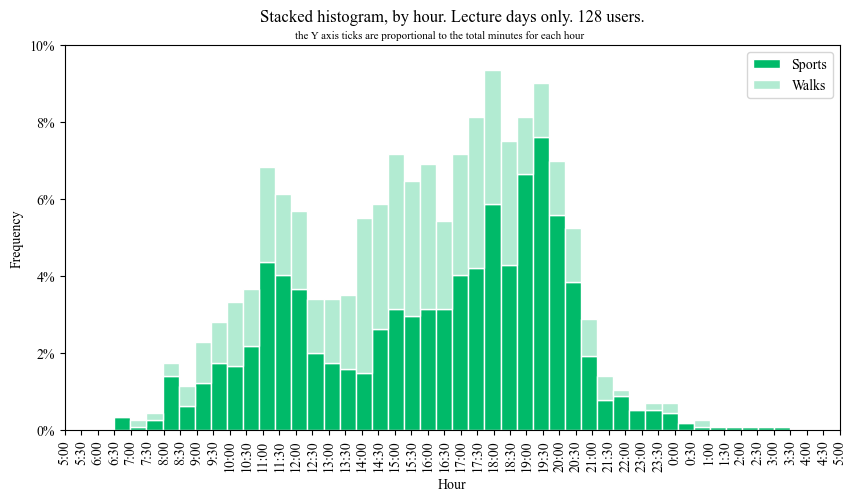

In [78]:
g1 = results[~results.day.isin(weekend_clock_days)]
g1.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g1['hour']]
n_of_bins = g1[(g1.what == 'Sport') | (g1.what == 'Walking') ].hour.unique().shape[0]

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)

ax.hist([g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"]],
        bins = n_of_bins,
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#00ba69", "#b2ebd2"),
       )
       
N = g1[g1.hour==0].shape[0] * (24 - 7.5)/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))

ax.set_xticks(np.arange(len(custom_order))/2)
ax.set_xticklabels(custom_order, rotation=90)

ax.yaxis.set_major_locator(plt.LinearLocator(6))
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0.0, 0.1*N)  # I want only to focus on a percentage of the whole distribution.

plt.title(f'Stacked histogram, by hour. Lecture days only. {g.id.unique().shape[0]} users.', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes for each hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('lecturedays.png')

plt.show()

## By hour (all days in one) weekends, all 128 users

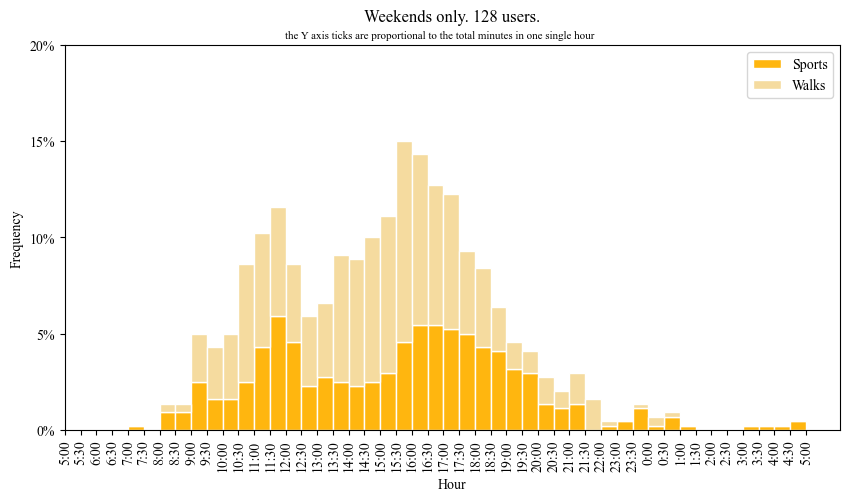

In [79]:
g2 = results[results.day.isin(weekend_clock_days)]

def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
g2.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g2['hour']]

f = plt.figure(figsize=(10,5))
ax = f.add_subplot(1,1,1)
n_of_bins = g2[(g2.what == 'Sport') | (g2.what == 'Walking') ].hour.unique().shape[0]
ax.hist([g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"]],
        bins = n_of_bins+3,
        stacked=True,
        edgecolor='white', label=['Sports', 'Walks'],
        color=("#ffb60f", "#f5db9f")
       )
       
N = g2[g2.hour == 0].shape[0] * (24 - 7.5)/24
ax.yaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))

ax.set_xticks(np.arange(len(custom_order))/2)
ax.set_xticklabels(custom_order, rotation=90)

ax.yaxis.set_major_locator(plt.LinearLocator(5))

plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.ylim(0.001, 0.20*N)  # I want only 10% to show, because "inactive" time is massive compared to activity time. 



plt.title(f'Weekends only. {g.id.unique().shape[0]} users.', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.91, ha='center', fontsize=8)
plt.legend()
# plt.savefig('weekends.png')

plt.show()

In [80]:
g2[(g2.what == 'Sport') | (g2.what == 'Walking') ].hour.value_counts().sort_index().shape[0]

40

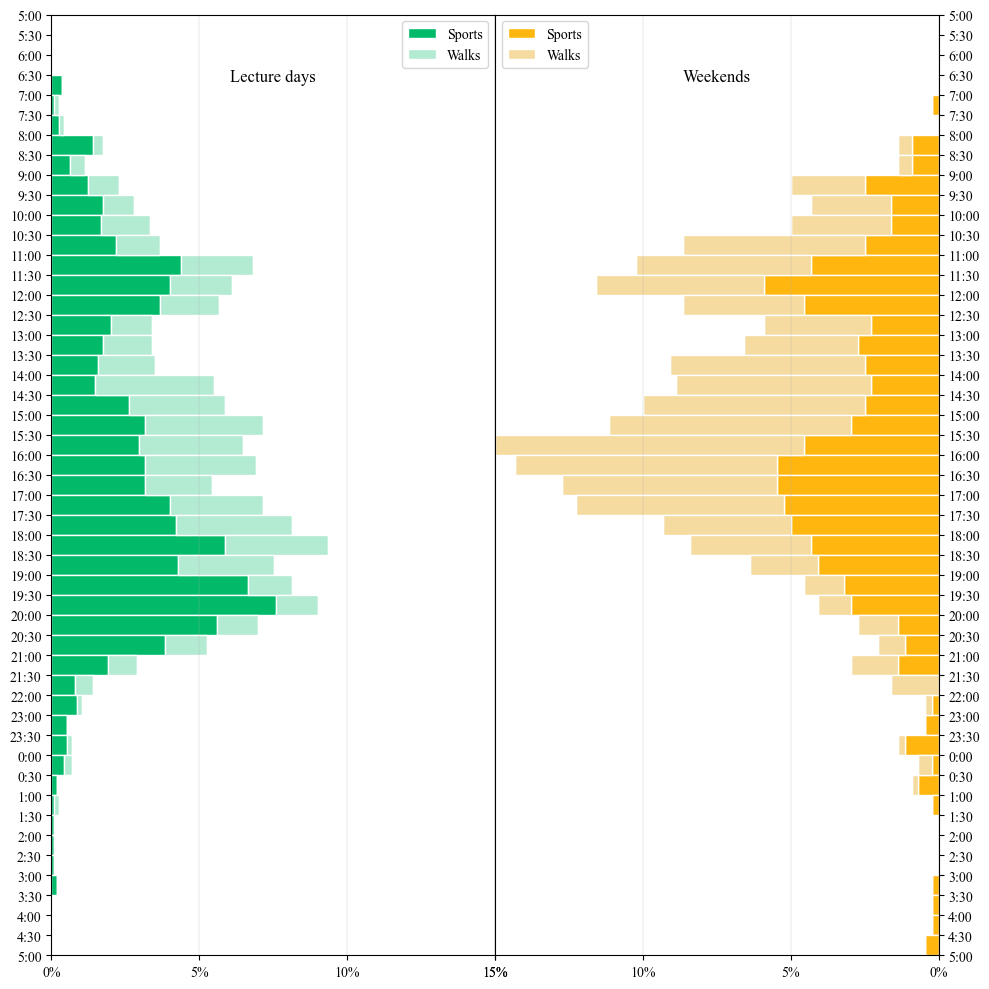

In [207]:
values1, values2 = [g1['hour'][g1['what'] == 'Sport'], g1['hour'][g1['what'] == "Walking"], g1['hour'][g1['what'] == 'Inactive']], [
    g2['hour'][g2['what'] == 'Sport'], g2['hour'][g2['what'] == "Walking"], g2['hour'][g2['what'] == 'Inactive']]
n_of_bins = g1[(g1.what == 'Sport') | (g1.what == 'Walking') ].hour.unique().shape[0]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
ax1.hist(values1,
         bins= n_of_bins-1,
         stacked=True,
         edgecolor='white', label=['Sports', 'Walks'],
         color=("#00ba69", "#b2ebd2", "#ffffff"),
         orientation = "horizontal",
        )

N1 = round(g1[g1['hour'] == 0].shape[0] * (24 - 7.5)/24)

ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N1, decimals=0))
ax1.xaxis.set_major_locator(plt.LinearLocator(4))

ax1.set_title('Lecture days', y = 0.92)
ax1.set_yticks(np.arange(len(custom_order))/2)
ax1.set_yticklabels(custom_order)
ax1.invert_yaxis()

ax1.set_xlim(0, 0.15* N1)


ax1.grid(axis='x', linewidth=0.2)
ax1.legend()

# Second subp, sharex=Truelot
ax2 = fig.add_subplot(1, 2, 2)  # 1 row, 2 columns, second subplot

n_of_bins = g2[(g2.what == 'Sport') | (g2.what == 'Walking') ].hour.unique().shape[0]

ax2.hist(values2,
         bins= n_of_bins+3,
         stacked=True, edgecolor='white', label=['Sports', 'Walks'],
         color=("#ffb60f", "#f5db9f", "#ffffff"),
         orientation = "horizontal")

N2 = round(g2[g2['hour'] == 0].shape[0] * (24 - 7.5)/24)

ax2.set_yticks(np.arange(len(custom_order))/2)
ax2.set_yticklabels(custom_order)
ax2.set_title('Weekends', y = 0.92)

ax2.xaxis.set_major_formatter(PercentFormatter(N2,decimals=0) )
ax2.xaxis.set_major_locator(plt.LinearLocator(4))

ax2.set_ylim(0,23.5)
ax2.set_xlim(0, 0.15*N2)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.yaxis.tick_right() 
ax2.legend(loc='upper left')
ax2.grid(axis='x', linewidth=0.2)

 
# plt.suptitle("the Y axis ticks are proportional to the total minutes in one single hour", y=0.90, ha='center', fontsize=8)
plt.tight_layout()
fig.subplots_adjust(wspace=0.0) 
plt.savefig('weekends_vs_lectures.jpg', dpi = 600)

plt.show()

### Summary statistics

In [82]:

std_deviation_wholetime = results[(results.what == 'Sport') | (results.what == 'Walking')].hour.std()
avg = results[(results.what == 'Sport') | (results.what == 'Walking')]['hour'].mean()
print("Whole distribution:")
print(f"Hourly standard deviation: {math.floor(std_deviation_wholetime)} hours and {std_deviation_wholetime%1*60:.5f} minutes. Mean hour: {avg + 5}")

std_deviation_wholetime = g2[(g2.what == 'Sport') | (g2.what == 'Walking')].hour.std()
avg = g2[(g2.what == 'Sport') | (g2.what == 'Walking')]['date_not'].dt.hour.mean()
print('Only selecting weekends:')
print(f"Hourly standard deviation: {math.floor(std_deviation_wholetime)} hours and {std_deviation_wholetime%1*60:.5f} minutes. Mean time: {avg}")

Whole distribution:
Hourly standard deviation: 3 hours and 43.12000 minutes. Mean hour: 15.27951127819549
Only selecting weekends:
Hourly standard deviation: 3 hours and 25.18816 minutes. Mean time: 14.362255965292842


In [83]:
g2[(g2.what == 'Sport') | (g2.what == 'Walking')]['date_not'].dt.time.mode()

0    15:30:00
Name: date_not, dtype: object

In [84]:
weekend_sport  = g2[(g2.what == 'Sport')].shape[0] / g2[(g2.what == 'Sport') | (g2.what == 'Walking')].shape[0]
weekend_walks = g2[(g2.what == 'Walking')].shape[0] / g2[(g2.what == 'Sport') | (g2.what == 'Walking')].shape[0]

lecture_walks = g1[(g1.what == 'Walking')].shape[0] / g1[(g1.what == 'Sport') | (g1.what == 'Walking')].shape[0]
lecture_sport = g1[(g1.what == 'Sport')].shape[0] / g1[(g1.what == 'Sport') | (g1.what == 'Walking')].shape[0]

print(f"Percentage of walks on all events in weekends: {lecture_walks*100:.2f}%")
print(f"Percentage of sports on all events in weekends: {lecture_sport*100:.2f}%")
print()
print(f"Percentage of walks on all events in weekdays: {weekend_walks*100:.2f}%")
print(f"Percentage of sports on all events in weekends: {weekend_sport*100:.2f}%")

Percentage of walks on all events in weekends: 39.93%
Percentage of sports on all events in weekends: 60.07%

Percentage of walks on all events in weekdays: 57.81%
Percentage of sports on all events in weekends: 42.19%


In [85]:
g1[g1.what == 'Sport'].sport.unique()

array(['Other outdoor activities', 'Gymnastics and fitness',
       'Other indoor activities', 'Walking, Trekking, and hiking',
       'Jogging and running', 'Cycling, skiing, and skating',
       'Ball games'], dtype=object)

- Calculate the Standard Error (SE)
- Determine the Z-score for the Desired Confidence Level: at 99%, Z = 2.58
- Calculate the Margin of Error (MOE)
- Calculate the Confidence Interval:
CI = Observed Percentage ± MOE

In [86]:
import math
SE = math.sqrt(lecture_walks*(1-lecture_walks) / g1[(g1.what == 'Sport') | (g1.what == 'Walking')].shape[0])
Z = 2.58
MOE = SE*Z
CI = (f"{lecture_walks-MOE:.4f}", f"{lecture_walks+MOE:.4f}")
print(f"For a confidence interval at 99%, the amount of walks during lectures ({lecture_walks:.4f}) can be in between {CI[0]} and {CI[1]}")

SE = math.sqrt(weekend_walks*(1-weekend_walks) / g2[(g2.what == 'Sport') | (g2.what == 'Walking')].shape[0])
Z = 2.58
MOE = SE*Z
CI = (f"{weekend_walks-MOE:.4f}", f"{weekend_walks+MOE:.4f}")
print(f"For a confidence interval at 99%, the amount of walks during lectures ({weekend_walks:.4f}) can be in between {CI[0]} and {CI[1]}")

For a confidence interval at 99%, the amount of walks during lectures (0.3993) can be in between 0.3690 and 0.4296
For a confidence interval at 99%, the amount of walks during lectures (0.5781) can be in between 0.5361 and 0.6201


## By day and hour (all days in one week), all 128 users. Histogram (not working properly)


100%|██████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 15.66it/s]


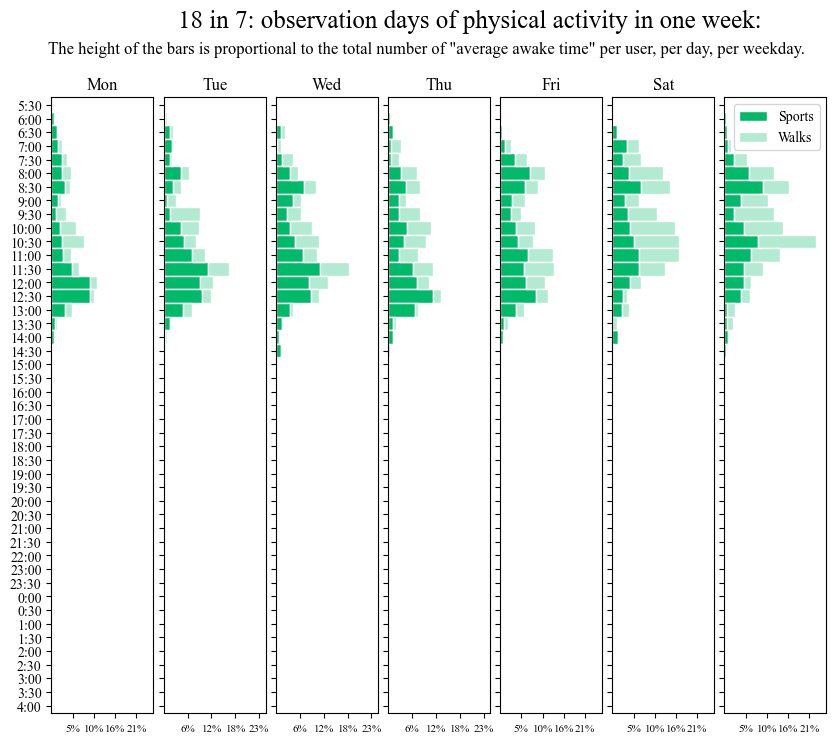

In [87]:
#For every day of the experiment, make one histogram. 
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.day == current_day]
    g.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g2['hour']]
    g = results[results.weekday == weekdays[current_day]]
    
    values = [g['hour'][g['what'] == 'Sport'], g['hour'][g['what'] == "Walking"]]
    ax1 = axs[current_day]
    ax1.hist(values,
             bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
             stacked=True,edgecolor='white', label=['Sports', 'Walks'],
             color=("#00ba69", "#b2ebd2"),
             orientation = "horizontal")
    ax1.set_xticks([])
    N = g[g['hour'] == 0].shape[0]
    ax1.set_xlim([0.001, 0.25*N])
    ax1.xaxis.set_major_formatter(PercentFormatter(xmax=N, decimals=0))
    ax1.set_title(f'{weekdays[current_day]}')    
    ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax1.xaxis.set_tick_params(labelsize=8)
    ax1.invert_yaxis()
    ax1.margins(y=-0.02)
    
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    #.margins(y=-0.02)
    
    
fig.subplots_adjust(wspace=0.1)   
plt.suptitle('The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.', y=0.95)
plt.title("18 in 7: observation days of physical activity in one week:", fontsize=18, y=1.1 , x=-2.5)
plt.legend()
plt.savefig('a_typical_week.png')
plt.show()


# Sport time intervals and other attributes
In this section, the data visualization will split observations between sexes, always regarding sport sessions but changing control variables. 

## Violinplots

In [88]:
#Violinplot instructions: 
'''
    # Extract relevant data for 'Sport' and 'Inactive'
    sport_data = g['hour'][g['what'] == 'Sport']
    inactive_data = g['hour'][g['what'] == 'Inactive']

    # Create a boxenplot using seaborn
    sns.violinplot(y=sport_data, color="#ff521b", ax=ax1, width=0.5)
'''
'''
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demo = demo_dataset[[ 'userid', 'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN', 'w1_A10UNITN']]

def which_day(t):
    return weekdays[t.weekday()]

results['weekday'] = results.date_not.apply(which_day)
fig, axs = plt.subplots(1, 7, sharex=False, sharey=True, figsize=(10, 8))
plt.yticks(np.arange(len(custom_order)), custom_order)

all_days = weekdays
for current_day in tqdm(range(0, len(all_days))):
    g = results[results.weekday == weekdays[current_day]]
    ax1 = axs[current_day]
    
    # Extract relevant data for 'Sport' and 'Inactive'
    sport_data = g['hour'][g['what'] == 'Sport']
    inactive_data = g['hour'][g['what'] == 'Inactive']
    merged_df = g.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates()
    merged_df['id'] = merged_df['id'].astype(int)

    # Use sns.catplot with 'kind="violin"'
    sns.catplot(
        x='weekday',
        y='hour',
        hue='w1_A01',
        ax=ax1,
        data=merged_df[(merged_df['what'] == 'Sport') & (merged_df['weekday'] == weekdays[current_day])],
        kind='violin',
        split=True
    )
    
    ax1.grid(axis='x')
    ax1.invert_yaxis()
    ax1.set_title(f'{weekdays[current_day]}')    
    if current_day == 0:
        ax1.yaxis.set_visible(True)
    else: 
        ax1.yaxis.set_visible(False)


fig.subplots_adjust(wspace=0.0)   
plt.suptitle('18 in 7: observation days of sport sessions in one week:', fontsize=18)
plt.text(0.5, 0.93, 'The height of the bars is proportional to the total number of "average awake time" per user, per day, per weekday.',
         fontsize=12, ha='center', va='center', transform=fig.transFigure)
plt.savefig('violinplot_typicalweek.png')
plt.show()
'''
()

()

In [89]:
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
demo = demo_dataset[[ 'userid', 'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN', 'w1_A10UNITN']]

def which_day(t):
    if t.hour < 5:    
        return weekdays[t.weekday()]  
    return weekdays[t.weekday()]

def order_days(i):
    if i == 'Mon':
        return 0
    elif i == 'Tue':
        return 1
    elif i == 'Wed':
        return 2
    elif i == 'Thu':
        return 3
    elif i == 'Fri':
        return 4
    elif i == 'Sat':
        return 5
    elif i == 'Sun':
        return 6
    
    
results['weekday'] = results.date_not.apply(which_day)

g = results.copy()

demo.loc[:, 'userid'] = demo['userid'].astype(int)
merged_df = g.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates().drop(columns="userid")
merged_df['id'] = merged_df['id'].astype(int)

merged_df['order'] = [order_days(i) for i in merged_df['weekday']]
merged_df = merged_df.sort_values(by='order')
sport_data = merged_df[(merged_df['what'] == 'Sport') | (merged_df['what'] != 'Sport')]

In [90]:
(445+301+300+275+271)/5

318.4

In [91]:
demo.department.unique()

['Engineering and Applied Sciences', 'Humanities', 'Agricultural', 'Social Sciences', 'Law', 'Medicine and veterinary medicine', 'Business/economics', 'Natural Sciences', NaN, 'International Relations and Public Administra...]
Categories (9, object): ['Business/economics' < 'International Relations and Public Administra... < 'Law' < 'Engineering and Applied Sciences' ... 'Natural Sciences' < 'Humanities' < 'Medicine and veterinary medicine' < 'Agricultural']

In [92]:
colors = list(Color('#00ba69').range_to(Color("#ffb60f"),7))
colors = [str(color) for color in colors]
colors

['#00ba69', '#00c833', '#0cd600', '#54e400', '#a5f200', '#fdff01', '#ffb60f']

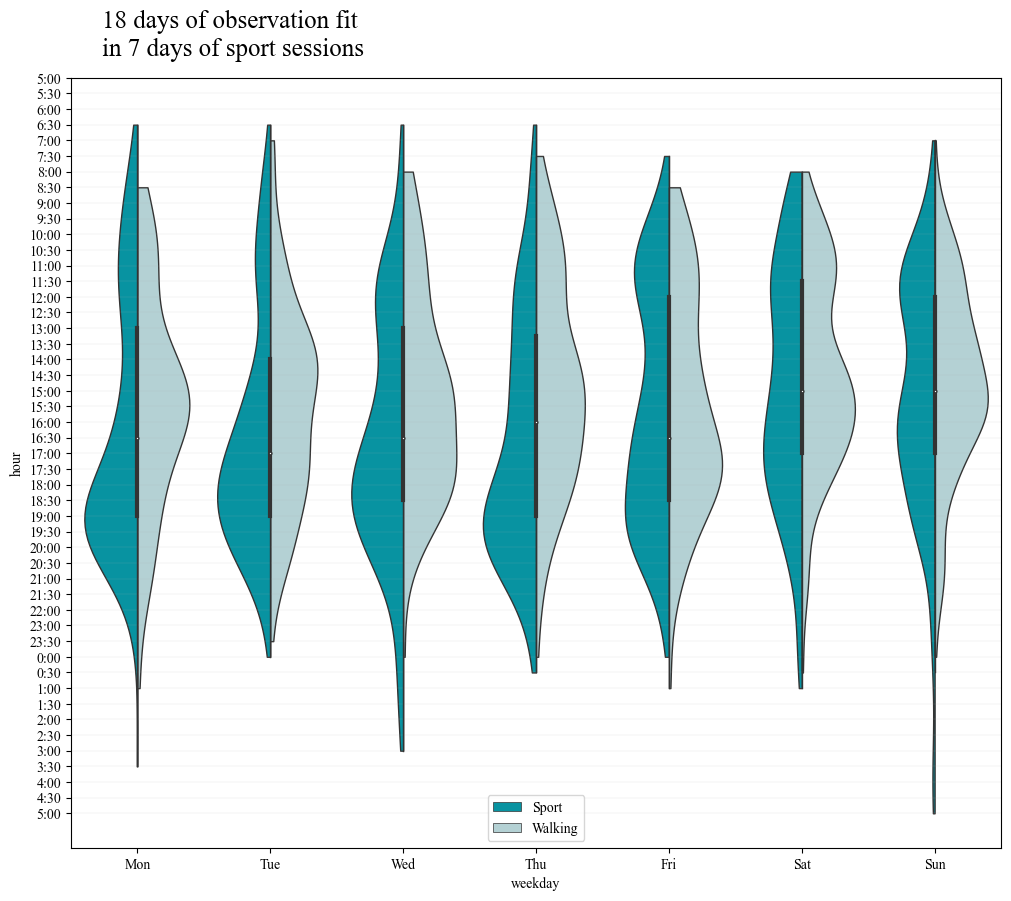

In [93]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
g = results.copy()
g.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g['hour']]
g.loc[:,'order'] = [order_days(i) for i in g['weekday']]
g = g.sort_values(by='order')

sns.violinplot(
    data=g[(g.what == 'Sport') | (g.what == 'Walking')],  # Filter for 'Sport' sessions
    x="weekday",
    y="hour",
    hue="what",
    inner="box",
    split=True,
    palette = sns.color_palette(["#0893a1", "#b4d1d4"]),
    dodge=True,
    common_norm = True,
    linewidth=1,
    saturation=1,
    linecolor='#6dbd83',
    cut=0
)

axs.set_yticks(np.arange(len(custom_order))/2)
axs.set_yticklabels(custom_order)

#axs.set_ylim(-7, 26)
axs.invert_yaxis()
plt.suptitle(f'{sport_data.day.unique().shape[0]} days of observation fit \nin 7 days of sport sessions', 
             fontsize=18, y=0.948, x = 0.26,  fontproperties=prop)
plt.grid(axis='y', linewidth=0.1)
plt.legend(loc='lower center')
plt.savefig('one_week.png')
plt.show()

In [94]:
F = demo.w1_A01.value_counts().iloc[0]
M = demo.w1_A01.value_counts().iloc[1]
N = F + M 
print(f'The Female to Male ratio in the whole sample is:  {F}/{M} = {F/M:.2f}') 

F = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts().iloc[0]
M = demo[demo.userid.isin(sport_data.id.unique())].w1_A01.value_counts().iloc[1]
print(f'Now, between the people who practiced sport at least once, the same ratio is: {F}/{M} = {F/M}')

The Female to Male ratio in the whole sample is:  142/107 = 1.33
Now, between the people who practiced sport at least once, the same ratio is: 70/56 = 1.25


In [95]:
def which_sex(userid):
    if userid in demo.userid.unique():
        return demo[demo.userid == userid].w1_A01.values[0]
    return np.nan
g['sex'] = [which_sex(userid) for userid in g.id]

In [96]:
sex_rates = []
for i in g.weekday.unique():   #this gets sex rates for each weekday. 
    F = g[(g.sex == 'Female') & ((g.weekday == i) & (g.what == 'Sport') | 
                     (g.weekday == i) & (g.what == 'Walking'))
                     ].sex.value_counts().iloc[0]
    M = g[(g.sex == 'Male') & ((g.weekday == i) & (g.what == 'Sport') | 
                     (g.weekday == i) & (g.what == 'Walking'))
                     ].sex.value_counts().iloc[0]
    sex_rates.append(f'{F/M:.2f}') 
    

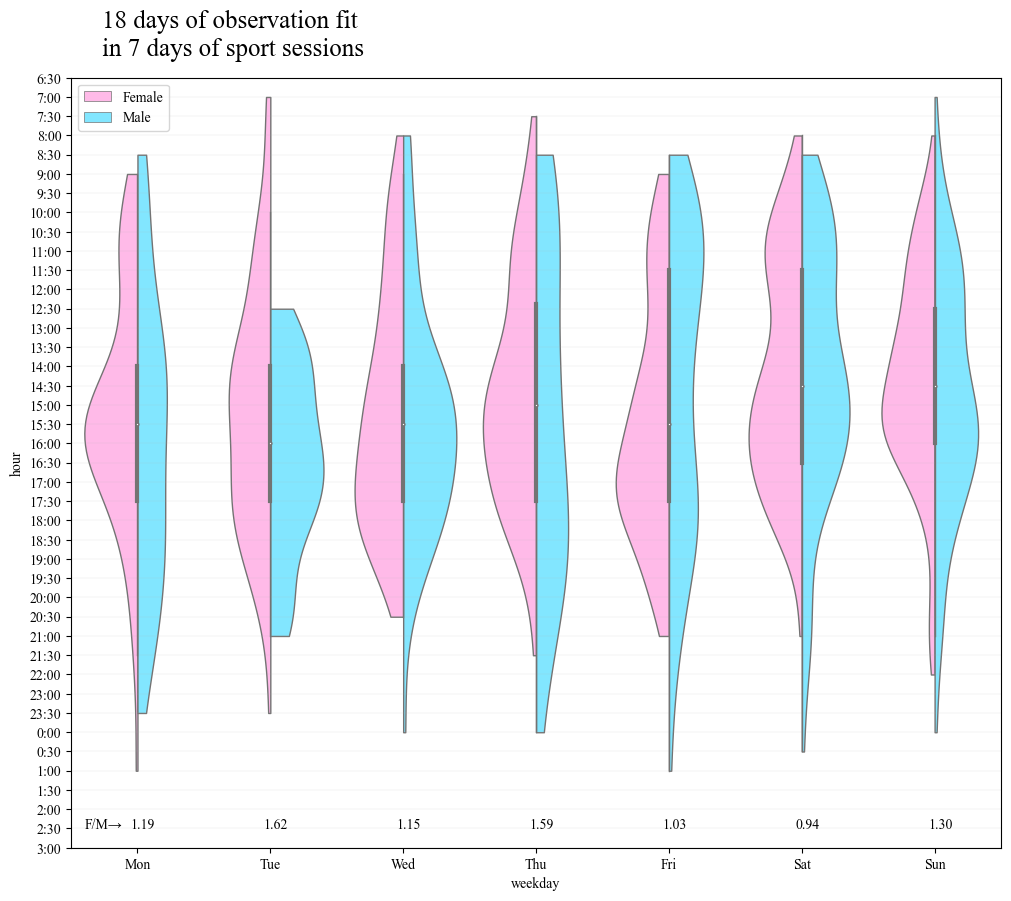

In [97]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
g['order'] = [order_days(i) for i in g['weekday']]
g = g.sort_values(by='order')

sns.violinplot(
    data=g[(g.what == 'Walking') |(g.sport == 'Walking, Trekking, and hiking')],  # Filter for 'Sport' sessions
    x="weekday",
    y="hour",
    hue="sex",
    inner="box",
    split=True,
    palette = sns.color_palette(['#ffbae8', '#82e6ff']),
    dodge=True,
    common_norm = True,
    linewidth=1,
    saturation=1,
    linecolor='#6dbd83',
    cut=0
)

axs.set_yticks(np.arange(len(custom_order))/2)
axs.set_yticklabels(custom_order)
axs.set_ylim(1.5,21.5)
axs.invert_yaxis()
plt.suptitle(f'{sport_data.day.unique().shape[0]} days of observation fit \nin 7 days of sport sessions', 
             fontsize=18, y=0.948, x = 0.26,  fontproperties=prop)
# plt.text(0.7, 0.17, f'F/M ratio: {F/M}.', #\nThe AUC is plotted using a kernel density estimation\n                        of the distribution for each day',
         # fontsize=12, ha='left', va='center', transform=fig.transFigure,  fontproperties=prop)
plt.text(-0.4, 21, 'F/M→', fontproperties=prop)
for i in range(0, 7, 1):
    plt.text(i-0.05, 21,sex_rates[i], fontproperties=prop)
plt.grid(axis='y', linewidth=0.1)
plt.legend(loc='upper left')
plt.savefig('one_week.png')
plt.show()

In [98]:
def which_department(userid):
    if userid in demo.userid.unique():
        return demo[demo.userid == userid].department.values[0]
    return np.nan
g['department'] = [which_department(userid) for userid in g.id]

In [99]:
g.department

0        Engineering and Applied Sciences
40522    Engineering and Applied Sciences
40521    Engineering and Applied Sciences
40520    Engineering and Applied Sciences
40474    Engineering and Applied Sciences
                       ...               
9075                     Natural Sciences
9076                     Natural Sciences
9077                     Natural Sciences
26175                  Business/economics
17709    Engineering and Applied Sciences
Name: department, Length: 110592, dtype: object

In [100]:
#Now, reclassifying the different degrees into 
stem = ['Natural Sciences', 'Medicine and veterinary medicine', 'Engineering and Applied Sciences', 'Agricultural', 'International Relations and Public Administration']
human = ['Law', 'Humanities']
soc_scien = ['Social Sciences', 'Business/economics']
print(len(g.department.unique()), len(stem + human + soc_scien)) #nan is excluded

fields = []
for department in g.department: 
    if department in stem: 
        fields.append('STEM')
    elif department in human: 
        fields.append('Humanities')
    elif department in soc_scien:
        fields.append('Social Sciences')
    else: 
        fields.append('nan')
g.loc[:, 'field'] = fields
g.field.unique()

10 9


array(['STEM', 'Humanities', 'nan', 'Social Sciences'], dtype=object)

In [101]:
custom_order = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00', '8:30', 
                '9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00', '12:30', 
                '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', '16:00', '16:30', 
                '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', 
                '21:00', '21:30','22:00', '23:00', '23:30', '0:00', '0:30', '1:00', '1:30', 
                '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00']

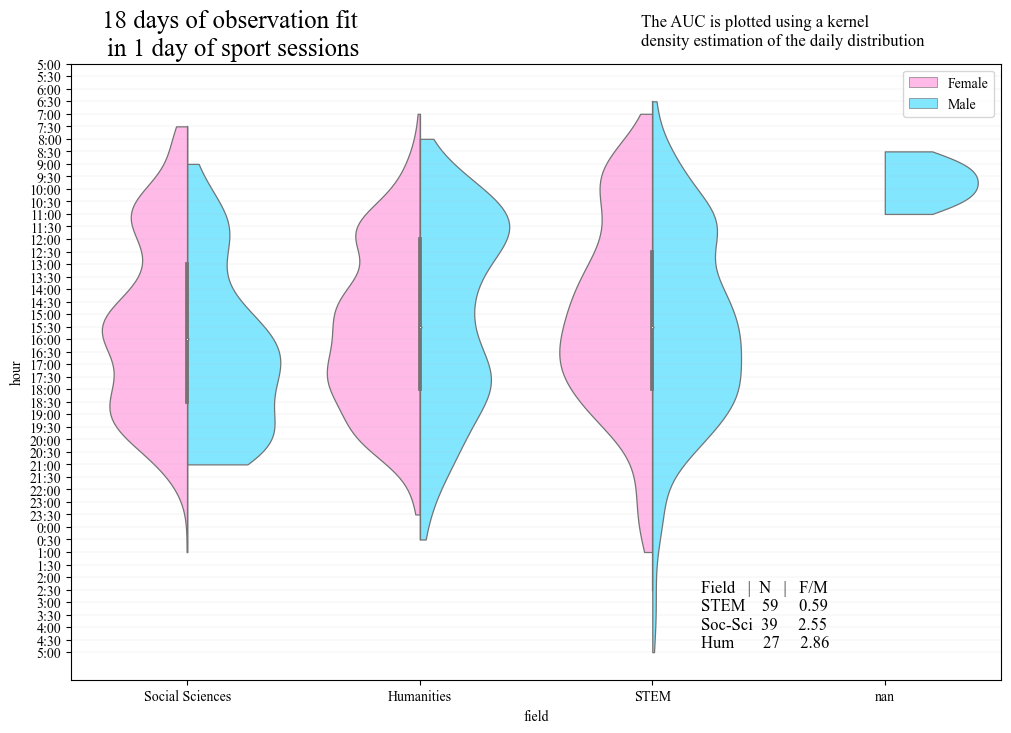

In [102]:
fig, axs = plt.subplots(1, 1, figsize=(12, 8))
sns.violinplot(
    data= g[(g.what == 'Sport') | (g.what == 'Walking')].dropna(subset='field'),
    x="field",
    y="hour",
    hue="sex",
    fill=False,
    #split=True,
    palette=sns.color_palette(['#ffbae8', '#82e6ff']),
    dodge=True,
    split=True,
    linewidth=0.9,
    saturation=1,
    linecolor='#000000',
    legend=False,
    cut=0,
)
axs.invert_yaxis()
axs.set_yticks(np.arange(len(custom_order))/2)

# axs.yaxis.set_major_locator(plt.LinearLocator(5))
axs.set_yticklabels(custom_order)
plt.suptitle(f'18 days of observation fit \nin 1 day of sport sessions', 
             fontsize=18, y=0.948, x = 0.26, fontproperties=prop)

N = len(g.id.unique())

Nstem = len(g[(g['field'] == 'STEM')].id.unique())
Nsocsci = len(g[(g['field'] == 'Social Sciences')].id.unique())
Nhum = len(g[(g['field'] == 'Humanities')].id.unique())

ids = g[(g['field'] == 'STEM')].id.unique()
NFstem = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
stem = NFstem / (Nstem - NFstem)

ids = g[(g['field'] == 'Social Sciences')].id.unique()
NFsocsci = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
soc_sci = NFsocsci / (Nsocsci - NFsocsci)

ids = g[(g['field'] == 'Humanities')].id.unique()
NFhum = demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']
hum = NFhum / (Nhum - NFhum)

plt.text(0.65, 0.19, f'\
Field   |  N   |   F/M \
\nSTEM    {Nstem}    {stem : .2f}\
\nSoc-Sci  {Nsocsci}    {soc_sci : .2f} \
\nHum       {Nhum}    {hum : .2f}',
         fontsize=12, ha='left', va='center', transform=fig.transFigure, fontproperties=prop)

plt.text(0.6, 0.92, f'The AUC is plotted using a kernel \ndensity estimation of the daily distribution',
         fontsize=12, ha='left', va='center', transform=fig.transFigure, fontproperties=prop)

plt.grid(axis='y', linewidth=0.1)
plt.legend()
plt.savefig('fieldandgender.png')
plt.show()

### Ratios and frequency of activities

In [103]:
22/37

0.5945945945945946

In [104]:
ids = g[(g['field'] == 'Social Sciences')].id.unique()
demo[demo.userid.isin(ids)].w1_A01.value_counts()['Female']

28

In [105]:
import statistics
males = sport_data[sport_data.w1_A01 == 'Male']
females = sport_data[sport_data.w1_A01 == 'Female']

In [106]:
print(statistics.variance(females.hour))
print(statistics.median(females.hour))
print(statistics.mode(females.weekday))

47.979959986110885
6.75
Mon


In [107]:
print(statistics.variance(males.hour))
print(statistics.median(males.hour))
print(statistics.mode(males.weekday))

47.9801583200711
6.75
Mon


In [108]:
td_dataset[(td_dataset.first2w == "First two weeks") & td_dataset.id.isin(males.id) & (td_dataset.week == 'Friday') & (td_dataset.date_not.dt.hour > 13)].what.value_counts()


what
Study/work group                                  477
No information                                    427
Watching TV, video, YouTube, etc.                 315
Eating                                            238
Lecture/seminar/conference/university meeting     190
Social life                                       153
Did not do anything special                       148
Games                                             132
Expired                                           121
Sleeping                                          109
Rest/nap                                           88
Personal care                                      84
Cooking, Food preparation & management             73
Household and family care                          72
Sport                                              72
Travelling                                         63
Walking                                            52
Other                                              48
Reading a book, periodi

In [109]:
td_dataset[(td_dataset.first2w == "First two weeks") & td_dataset.id.isin(females.id) & (td_dataset.week == 'Friday') & (td_dataset.date_not.dt.hour > 13)].what.value_counts()

what
No information                                    657
Study/work group                                  645
Watching TV, video, YouTube, etc.                 422
Eating                                            284
Lecture/seminar/conference/university meeting     183
Did not do anything special                       161
Personal care                                     156
Social life                                       148
Expired                                           117
Rest/nap                                          115
Phone/Video calling                               113
Sleeping                                          111
Household and family care                         101
Social media (Facebook Instagram etc.)            100
Sport                                              92
Cooking, Food preparation & management             88
Walking                                            79
Games                                              61
Reading a book, periodi

# Other analyses and remains of previous versions

In [110]:
# This data processing is solely for exploratory quick analyses on R (where decision trees classifiers
# are what I know best than scikit's decision trees)

merged_data = results.merge(demo, left_on='id', right_on='userid', how='left').drop_duplicates().drop(columns="userid")
merged_data.loc[:,'id'] = merged_data['id'].astype(int)
working_data = merged_data[['what','id', 'date_not', 'withw', 'where', 'day', 'weekday',
       'w1_A01', 'department', 'degree', 'w1_A04UNITN', 'w1_A09UNITN',
       'w1_A10UNITN']]

'''
to_drop = ["Expired", "I have a work/study meeting", "I am at the cinema/theater/hospital/church", "I will participate in sports activities", "Other","Others"]

for string in to_drop: 
    working_data['what'] = working_data['what'].replace(f'{string}', 'No Information')

working_data['what'] = working_data['what'].replace(["Arts", "Movie Theatre Concert ...", 
                                                     "Entertainment Exhibit, and Culture", 
                                                     "Others Entertainment and Culture"], "Hobbies")
'''


working_data.loc[:,'hour'] = working_data.date_not.dt.hour

working_data.loc[:,'withw'] = working_data['withw'].astype(str)
working_data.loc[:,'withw'] = working_data['withw'].replace('nan', 'No information')

working_data.loc[:,'where'] = working_data['where'].astype(str)
working_data.loc[:,'where'] = working_data['where'].replace('nan', 'No information')

working_data = working_data[working_data.id.isin(sport_data.id.unique())]
working_data = working_data.drop(['id', 'date_not', 'day'], axis='columns')

#working_data['what'] = working_data['what'] == 'Sport'
#working_data['what'] = working_data['what'].replace([True, False], ['Active', 'Inactive'])

to_recode = [el for el in working_data.w1_A10UNITN.unique()]

working_data.loc[:,'w1_A10UNITN'] = working_data['w1_A10UNITN'].replace(to_recode, ['Trento South',np.nan,
                                                                              'Center', 'North of Gardolo',
                                                                              'Piedicastello/Vela',
                                                                              'Mattarello/Ravina/Romagnano',
                                                                              'Trento North', 'Argentario/Marzola',
                                                                              'Argentario/Marzola',
                                                                              'Bondone'])

stem = ['Natural Sciences', 'Medicine and veterinary medicine', 'Engineering and Applied Sciences', 'Agricultural', 'International Relations and Public Administration']
human = ['Law', 'Humanities']
soc_scien = ['Social Sciences', 'Business/economics']
fields = []
for department in working_data.department: 
    if department in stem: 
        fields.append('STEM')
    elif department in human: 
        fields.append('Humanities')
    elif department in soc_scien:
        fields.append('Social Sciences')
    else: 
        fields.append('nan')

working_data = working_data[working_data['what'] == 'Sport']
working_data.to_csv('WeNeteventsdata.csv')

/tmp/ipykernel_972213/3156334699.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  working_data.loc[:,'hour'] = working_data.date_not.dt.hour


## Preparing data for R
The goal was to check which categories from which variables seem to divide better the data regarding the weekday of sport. The unpruned tree for sport data is in decision_tree_plot_weekday.pdf. It is unreadable but you can zoom in. These basic results will be checked with visualization. 

In [111]:
!pip install pillow

In [112]:
from matplotlib.animation import FuncAnimation
from itertools import repeat
from PIL import Image
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import itertools

In [113]:
g['where'] = g['where'].replace(['Home apartment /room','Relatives Home', 
                                                     'House (friends others)', 
                                                     'Home garden/patio/courtyard', 
                                                     'Weekend home or holiday apartment'], 
                                                    
                                                    'Home or someone\'s home')

g['where'] = g['where'].replace(['Café, pub, bar', 'Another indoor place', 'Shops, shopping centres'], 
                                                    'No information')

g['where'] = g['where'].replace('Countryside/mountain/hill/beach', 
                                                    'Mountains / hills')

g['where'] = g['where'].replace(['In the street', 'Another outdoor place'], 
                                                    'Outdoors in the city')
g['where'] = g['where'].replace(['Canteen',
                                                       'Other Library',
                                                       'Other university place',
                                                       'Grocery Shop',
                                                       'Supermarket …',
                                                       'Classroom/ Laboratory',
                                                       'Restaurant, pizzeria, Street food vendor',
                                                       'Movie Theatre Museum …',
                                                       'University Library',
                                                       'Classroom / Study hall',
                                                       'Workplace/office',
                                                       'Hotel, guesthouse, camping site',
                                                       'Travel',
                                                       'Not answer',
                                                       'Expired',
                                                       'Street markets'], 'Others')
g['where'] = g['where'].replace('Others', np.nan)
g['where'].value_counts()
g.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g['hour']]


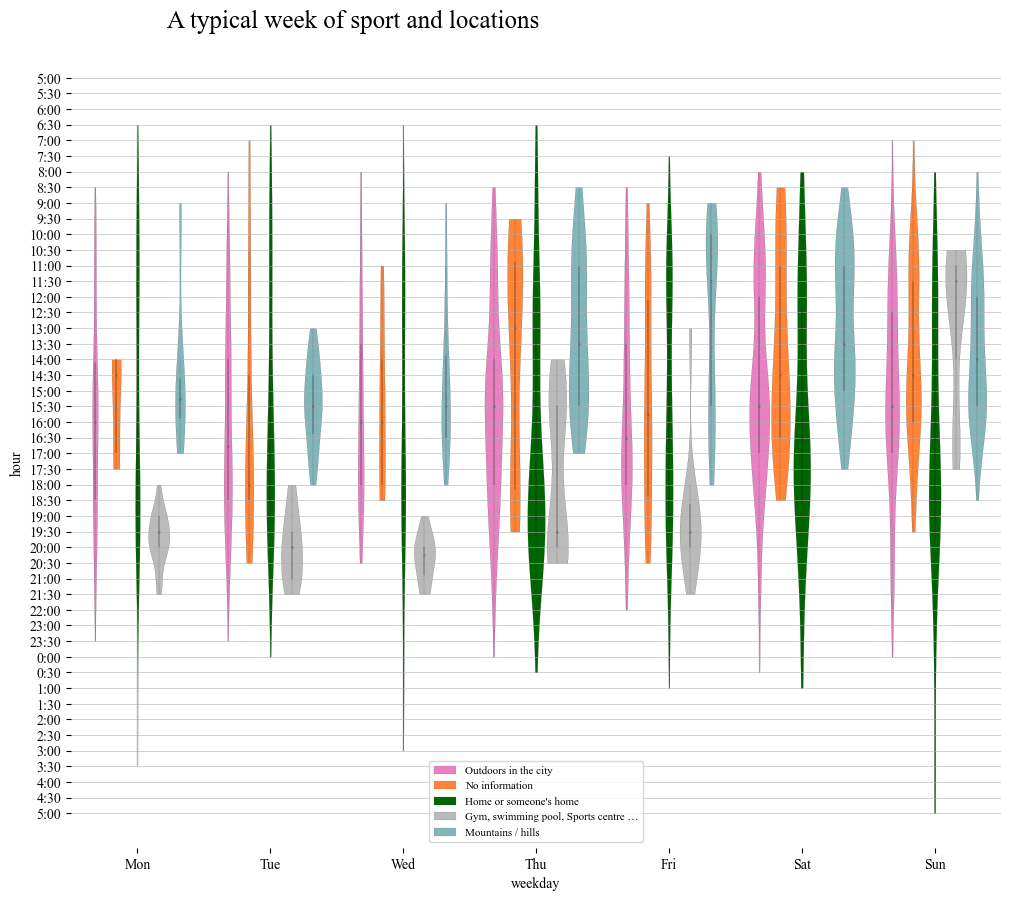

In [114]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
sns.violinplot(
        data=g[(g.what == 'Sport') | (g.what == 'Walking')],
        x="weekday",
        y="hour",
        hue="where",
        bw_method = 'silverman',
        native_scale=False,
        density_norm={'count'},
        palette=sns.color_palette(['#e681c2', '#ff8438', '#006602', '#bababa', '#82b5ba']),
        dodge=True,
        linewidth=0.1,
        saturation=1,
        linecolor='#000000',
        cut=0,
)
axs.set_yticks(np.arange(len(custom_order))/2)
axs.set_yticklabels(custom_order, fontsize=10)
axs.invert_yaxis()

plt.suptitle(f'A typical week of sport and locations', 
             fontsize=18, y=0.948, x = 0.36)

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
plt.legend(loc='lower center', prop={'size': 8})
plt.grid(axis='y', linewidth=0.4)
plt.savefig('week_sport_andlocations.png')
plt.show()

In [115]:
 197/ g[(g.what == 'Sport') | (g.what == 'Walking')]['where'].value_counts().sum()  #7.4% of all observations are No Information.

0.07470610542282898

In [116]:
g[(g.what == 'Sport') & (g['where'] == 'Outdoors in the city') | (g.what == 'Walking')  & (g['where'] == 'Outdoors in the city')].sport.value_counts()

sport
Jogging and running              85
Cycling, skiing, and skating     45
Walking, Trekking, and hiking    34
Other outdoor activities         12
Water sports                      7
Gymnastics and fitness            2
Name: count, dtype: int64

## Swarmplot for routine

In [117]:
# Users who did sport AT LEAST once will be submitted to this algorithm.
IDs = g[(g['what'] == 'Sport') ].id.unique()

user_activity = dict()
for ID in tqdm(IDs):
    id_act = g[(g['what'] == 'Sport') & (g.id == ID)]
    user_activity[ID] = list(id_act.date_not.dt.day.sort_values().unique())
# print(f'At first there were about {g.id.unique().shape[0]} users. Now: N = ',len(user_activity.keys())) 
print("User dictionary with sorted unique user-specific observation days is done.")

def gantt_data_org(k, v):
    
    ''' 
    gantt_data is named after the Gantt chart.
    S is the Series of days (regardless of when they start).
    '''
    
    tot = 1  #this is already a sample of people who we know practiced sport at least once.
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        start, end = v[0], v[-1]
        
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            # if there is more than two days of difference it means that there was more than one
            # day in the data with no observations, and it is unlikely it's consistent data.
            tot += 1
            if difference >= 2:    
                break
            else:
                consecutive = True
        
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['id', 'start', 'finish', 'tot', 'cons'])

gantt_data = pd.DataFrame(columns=["id", "start", "finish", "tot", "cons"])

for ID, days in user_activity.items():
    res = gantt_data_org(ID, days)
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)
print("The test is finished.")

100%|█████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 225.84it/s]


User dictionary with sorted unique user-specific observation days is done.
The test is finished.


In [118]:
gantt_data = gantt_data.sort_values(by=['tot'],ascending=True)
gantt_data.id = gantt_data.id.astype('str')
gantt_data

,id,start,finish,tot,cons
127,66,29,29,1,False
99,163,19,19,1,False
100,127,26,26,1,False
101,0,19,19,1,False
126,67,15,15,1,False
...,...,...,...,...,...
50,167,13,30,12,True
44,153,13,30,13,True
5,185,13,30,14,True
19,19,13,30,14,True


/home/fluve/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


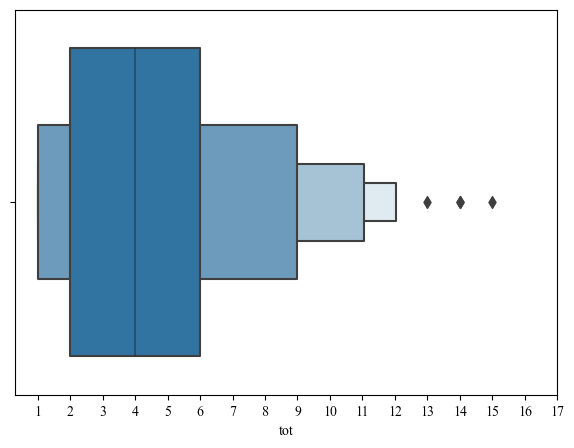

In [119]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5))
# I NEED TO PLOT, CONSECUTIVELY, THE DISTRIBUTION OF DAYS BY USER AND ORDER IT. 
b = gantt_data
sns.boxenplot(data= b,
           x='tot')
axs.set_xticks(range(1,18))
axs.set_xticklabels(np.arange(1,18))
plt.show()

#### Comment:
Having looked at the number of total days in which a user said they were doing sport, I choose to keep only users who practiced at least 8 days for the next visualization that requires observations from participants that could be very regular. 

In [120]:
to_keep = gantt_data[(gantt_data.tot>4)].id.astype(str)
# print(f"Selected users: {to_keep.shape[0]}, equal to the top {(to_keep.shape[0]/gantt_data.shape[0])*100:.2f}%")
g.id = g.id.astype('str')
g[(g['what'] == 'Sport') ].loc[:, 'tot'] = [   g[(g['what'] == 'Sport') & (g.id == ID)].shape[0] for ID in g[(g['what'] == 'Sport') ].id]
# g.loc[:, 'tot'] = [gantt_data[gantt_data.id == i].tot.values[0] for i in g.id]

/tmp/ipykernel_972213/3319226091.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g[(g['what'] == 'Sport') ].loc[:, 'tot'] = [   g[(g['what'] == 'Sport') & (g.id == ID)].shape[0] for ID in g[(g['what'] == 'Sport') ].id]


In [121]:
colors = list(Color('#001eff').range_to(Color("#b03e00"),9))
colors = [str(color) for color in colors]

In [196]:
weekdays
wholeweekdays = ['Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [197]:
colors = ['#1400f2', '#d68b00', '#7cb500', '#7cb500', '#b50300', '#415251','#006625']

/home/fluve/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fluve/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


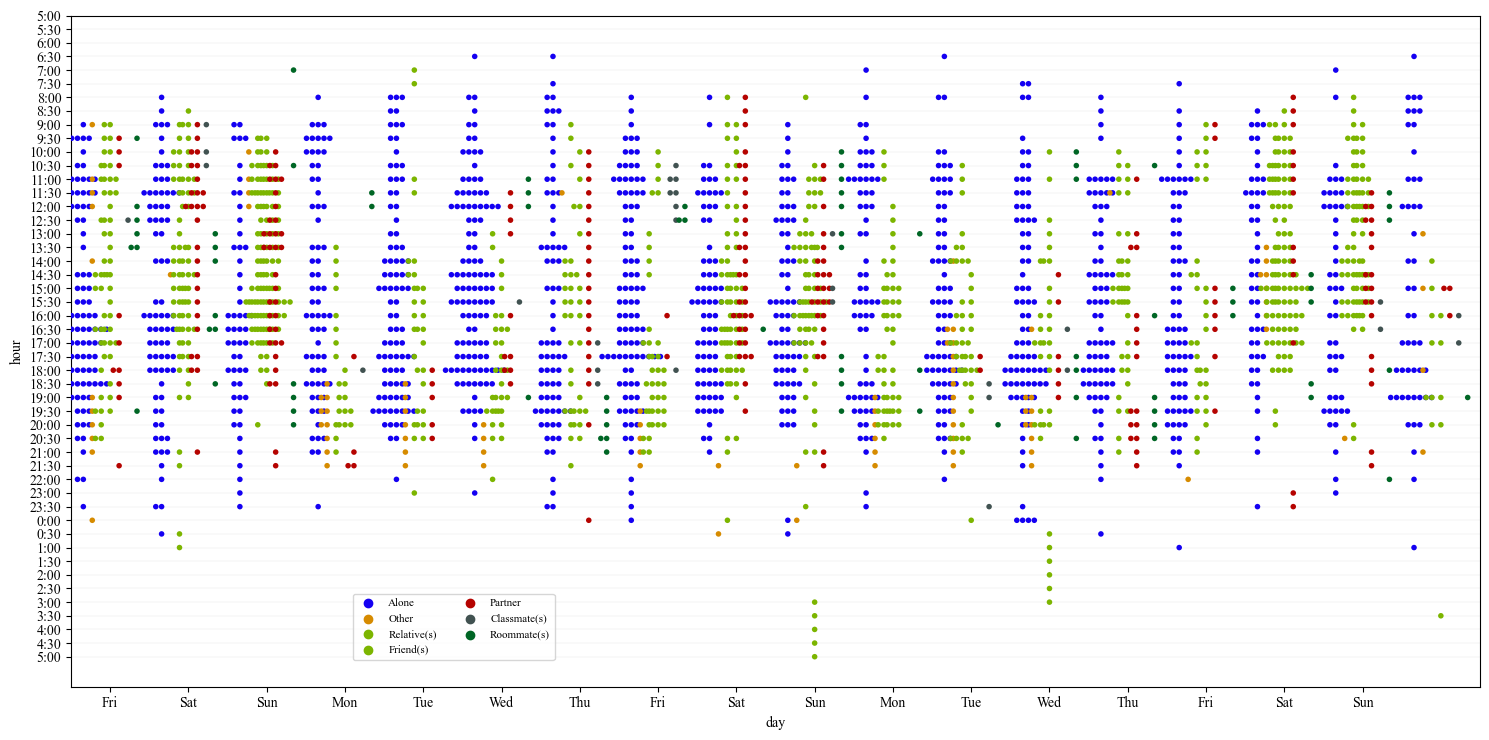

In [200]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7.5))
sns.swarmplot(data= g[(g.what == 'Sport') | (g.what == 'Walking')],
              y='hour', x='day',
              hue= 'withw',
              color=None,  size=4, 
              edgecolor=None, linewidth=0, 
              hue_norm=None, 
              dodge=True,
              palette=sns.color_palette(colors),
              native_scale=False, warn_thresh=0.1)


axs.invert_yaxis()
axs.set_yticks(np.arange(len(custom_order))/2)
axs.set_yticklabels(custom_order)
axs.set_xticks(np.arange(len(wholeweekdays)))
axs.set_xticklabels(wholeweekdays)
plt.legend(loc=(0.2, 0.04), prop={'size': 8}, ncol=2)
plt.grid(axis= 'y', lw=0.1)
plt.tight_layout()
plt.savefig("no_pattern_company.jpg", dpi = 200)
plt.show()

In [202]:
colors =  ['#d68b00', '#7cb500', '#7cb500', '#b50300', '#415251','#006625']

/home/fluve/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/fluve/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


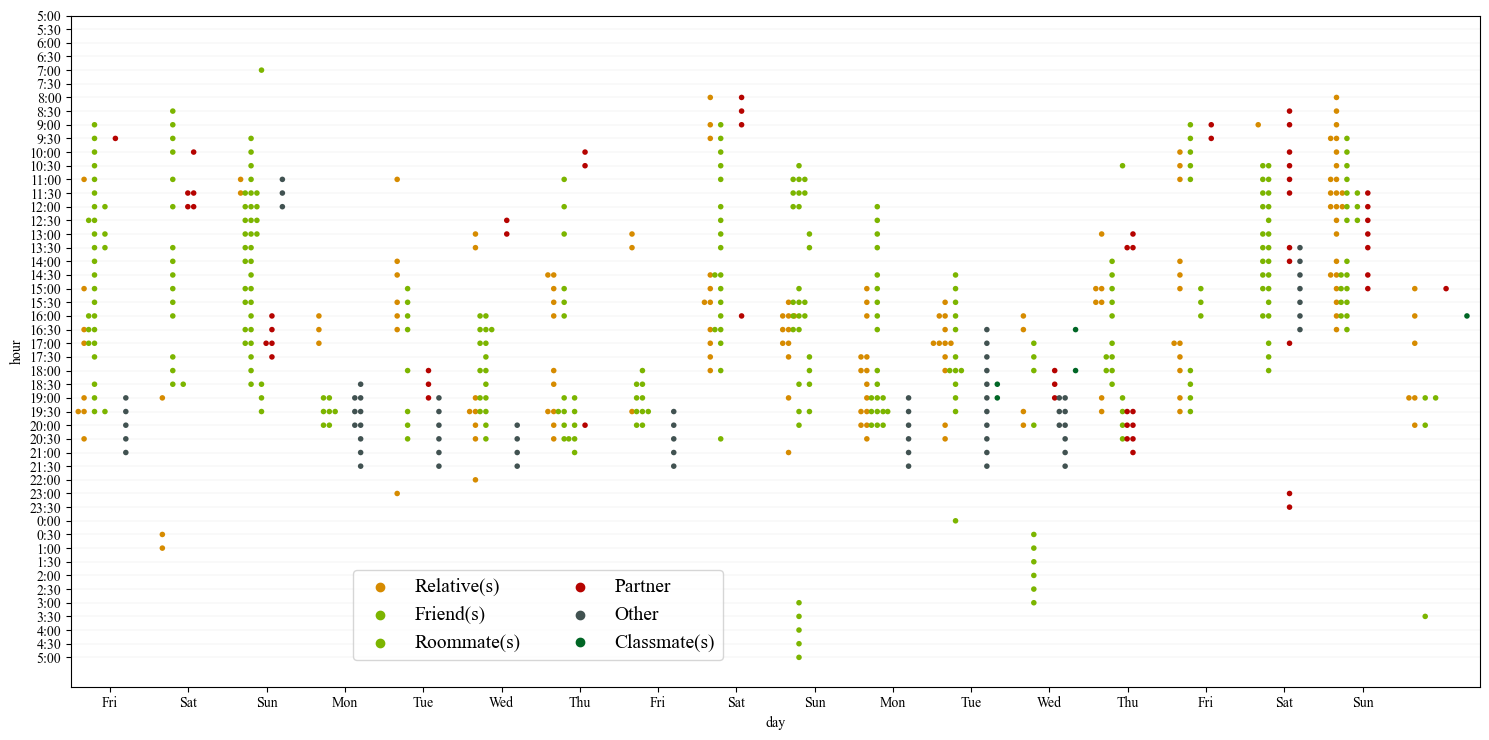

In [203]:
fig, axs = plt.subplots(1, 1, figsize=(15, 7.5))
sns.swarmplot(data= g[(g.what == 'Sport') & (g.withw != 'Alone')], 
              y='hour', x='day',
              hue= 'withw',
              color=None,  size=4, 
              edgecolor=None, linewidth=0, 
              hue_norm=None, 
              dodge=True,
              palette=sns.color_palette(colors),
              native_scale=False, warn_thresh=0.1)

axs.invert_yaxis()
axs.set_yticks(np.arange(len(custom_order))/2)
axs.set_yticklabels(custom_order)
axs.set_xticks(np.arange(len(wholeweekdays)))
axs.set_xticklabels(wholeweekdays)
plt.legend(loc=(0.2, 0.04), prop={'size': 14}, ncol=2)
plt.grid(axis= 'y', lw=0.1)
plt.tight_layout()
plt.savefig("with_pattern_company.jpg", dpi = 200)
plt.show()

In [160]:
print(g[(g.what == 'Sport') & (g.withw != 'Alone')].shape[0])
print(g[(g.what == 'Sport')].shape[0])

588
1433


In [126]:
g.week

0           NaN
40522    Monday
40521    Monday
40520    Monday
40474    Monday
          ...  
9075     Sunday
9076     Sunday
9077     Sunday
26175    Sunday
17709    Sunday
Name: week, Length: 110592, dtype: object

# Remainders

In [127]:
graphdata = working_data

graphdata['where'] = graphdata['where'].replace('No information', 'Home or someone\'s home')

pub_pri = {'Home or someone\'s home':'private', 'Outdoors in the city':'public', 
           'Gym, swimming pool, Sports centre …':'public', 'Mountains / hills':'private'}

out_ind = {'Home or someone\'s home':'indoor', 'Outdoors in the city':'outdoor', 
           'Gym, swimming pool, Sports centre …':'indoor', 'Mountains / hills':'outdoor'}

graphdata['pub_pri'] = [pub_pri[cell] for cell in graphdata['where']]
graphdata['out_ind'] = [out_ind[cell] for cell in graphdata['where']]
data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [12]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
graphdata = pd.concat([graphdata, pd.DataFrame(data)], ignore_index=True)

grey_patch = mpatches.Patch(color=mcolors.hex2color('#82b5ba'))
green_patch = mpatches.Patch(color = mcolors.hex2color('#71ab7d'))
pink_patch = mpatches.Patch(color=mcolors.hex2color('#e681c2'))
orange_patch = mpatches.Patch(color = mcolors.hex2color('#ff8438'))


fig, ax = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

def update(frame):
    ax[0].cla()
    ax[1].cla()
    
    # FIRST SECTION
    g1 = sns.violinplot(data=graphdata[(graphdata['weekday'] == frame[:3]) & 
                                       (graphdata['out_ind'] == 'outdoor')],
                        x='out_ind', y='hour',
                        hue="pub_pri",
                        ax=ax[0],
                        split=True,
                        dodge=True,
                        linewidth=0.4,
                        saturation=1,
                        cut=0.1,
                        palette=sns.color_palette(['#82b5ba', '#71ab7d']),
                        linecolor='#000000')
    ax[0].set_yticks(np.arange(len(custom_order)))
    ax[0].set_yticklabels(custom_order)
    ax[0].invert_yaxis()
    ax[0].grid(axis='y')
    ax[0].set_xlabel('')
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)

    ax[0].legend([grey_patch, green_patch], ['Outdoors in the city', 'Mountain / Hills'],
                 loc='lower left', prop={'size': 8})

    # SECOND SECTION
    g2 = sns.violinplot(data=graphdata[(graphdata['weekday'] == frame[:3]) & 
                                       (graphdata['out_ind'] == 'indoor')],
                        x='out_ind', y='hour',
                        hue="pub_pri",
                        ax=ax[1],
                        split=True,
                        dodge=True,
                        linewidth=0.9,
                        cut=0.4,
                        saturation=1,
                        palette=sns.color_palette(['#e681c2', '#ff8438']),
                        linecolor='#000000')

    ax[1].set_yticks(np.arange(len(custom_order)))
    ax[1].set_yticklabels(custom_order)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].grid(axis='y')
    ax[1].legend([pink_patch, orange_patch], ['Home or somewhere \nprivate', 'Sport center'],
                 loc='lower right', prop={'size': 8})
    
    plt.suptitle(f'{frame}',
                 fontsize=18, y=0.948, x=0.36)
    fig.subplots_adjust(wspace=-0.0001)



animation = FuncAnimation(fig, update, frames=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                          interval=1500)
name = 'everyday_location_activity.gif'
animation.save(name, writer='imagemagick', fps=0.5)

plt.show()

KeyError: 'Café, pub, bar'

In [ ]:
test = working_data

test['where'] = test['where'].replace('No information', 'Home or someone\'s home')

pub_pri = {'Home or someone\'s home':'private', 'Outdoors in the city':'public', 
           'Gym, swimming pool, Sports centre …':'public', 'Mountains / hills':'private'}

out_ind = {'Home or someone\'s home':'indoor', 'Outdoors in the city':'outdoor', 
           'Gym, swimming pool, Sports centre …':'indoor', 'Mountains / hills':'outdoor'}

test['pub_pri'] = [pub_pri[cell] for cell in test['where']]
test['out_ind'] = [out_ind[cell] for cell in test['where']]

data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [12]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
test = pd.concat([test, pd.DataFrame(data)], ignore_index=True)

In [ ]:
frame='Sunday'

indoor_data = test[(test['weekday'] == frame[:3]) & (test['out_ind'] == 'indoor')]

data = {
    'date_not': [np.nan]*2,
    'id': [np.nan]*2,
    'what': [np.nan]*2,
    'withw': [np.nan]*2,
    'where': [np.nan]*2,
    'day': [np.nan]*2,
    'hour': [0]*2,
    'weekday': ['Sat', 'Sun'],
    'w1_A01': [np.nan]*2,
    'department': [np.nan]*2,
    'degree': [np.nan]*2,
    'w1_A04UNITN': [np.nan]*2,
    'w1_A09UNITN': [np.nan]*2,
    'w1_A10UNITN': [np.nan]*2,
    'order': [np.nan]*2,
    'field': [np.nan]*2,
    'pub_pri': ['public', 'public'],
    'out_ind': ['indoor', 'indoor']
}
indoor_data = pd.concat([indoor_data, pd.DataFrame(data)], ignore_index=True)



sns.violinplot(data = indoor_data[(indoor_data['weekday'] == frame[:3]) & 
                                (indoor_data['out_ind'] == 'indoor')], 
               x='out_ind', y='hour', 
               hue="pub_pri", 
               ax=ax[1],
               split=True,
               dodge=True,
               linewidth=0.9,
               cut = 0.4,
               saturation=1,
               palette = sns.color_palette(['#e681c2', '#ff8438']),
               linecolor='#000000')
indoor_data.pub_pri.unique()

## Appendix

In [ ]:
#First thing: remove the users that have no qualified sport sessions 
print(f"Difference in id number from clean to cleaner: {len(sport_eve.id.unique())} - {len(cat_dataset.id.unique())} = {len(sport_eve.id.unique()) - len(cat_dataset.id.unique())}")
to_remove = list(sport_eve[~(sport_eve['id'].isin(cat_dataset.id.unique()))].index)
print(f"Rows:{sport_eve.shape[0]}")
print('removing...')
cl_sport_eve = sport_eve.drop(index=to_remove)
print(f"Rows:{cl_sport_eve.shape[0]}")
print(len(cl_sport_eve.id.unique()))

In [ ]:
# reminder: sport_eve is the dataset from the raw data that has 
# all the events in which users indicated they were walking or doing sports. 
# it does not have the inactive events (that were artificially added as you see in previous sections. 

        #Baby example of what's going on: 

    # for every user, for every observation in the cleaner dataset:
    
user = 9
first = cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp.tolist()[0]  #[0] means I only get the first as an example
print(first)
#the end is just the start + duration time so:
duration_in_hours = cat_dataset[cat_dataset.id ==9].sort_values(by='timestamp').duration.tolist()[0] // 60
second = first + timedelta(hours=duration_in_hours, seconds=1)

#window of time for acceptable observations:
range_to_check = pd.date_range(start=first, end=second, freq='30T')

    #for every user, for every observation:
user_data = cl_sport_eve[cl_sport_eve.id == 9].sort_values(by='date_not')

to_keep = user_data.date_not.isin(range_to_check)
user_data[to_keep].head()  #now only outputting the events during a sport session.

# Ta daa! Now I will automate this process.

In [ ]:
cat_dataset[cat_dataset.id == 9].sort_values(by='timestamp').timestamp

In [ ]:
clean_events = pd.DataFrame()
for user in tqdm(cl_sport_eve.id.unique()):
    first = cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').reset_index().timestamp.tolist()
    duration_in_hours = (cat_dataset[cat_dataset.id == user].sort_values(by='timestamp').duration / 60).tolist()
    second = [first[i] + timedelta(hours=duration_in_hours[i], seconds=1) for i in range(len(duration_in_hours))]
    #first and second are now ready. 
    for i in range(len(first)):
        range_to_check = pd.date_range(start=first[i], end=second[i], freq='30T')
        
        #masking the other, less clean but eventful dataset 
        user_data = cl_sport_eve[cl_sport_eve.id == user].sort_values(by='date_not')
        to_keep = user_data.date_not.isin(range_to_check)
        user_data[to_keep]  
    clean_events = pd.concat([clean_events, user_data], ignore_index=True)    
    

In [ ]:
clean_events

In [ ]:
clean_events
#everything you see below was done at the start of this notebook, it's for making
# data more machine - readable
dictdays = dict()
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(0, 7):
    dictdays[i] = weekdays[i]
weekend_clock_days = [14, 15, 21, 22, 28]
print("The weekends:")
for day in weekend_clock_days:
    weekday = weekdays[clean_events[clean_events.date_not.dt.day == day].date_not.dt.dayofweek.values[0]]
    print(f"The date {day} was a {weekday}")
def today_or_yesterday(t): 
    if t.hour < 5:
        return days[t.day - 1]
    else:
        return days[t.day]

days = dict()
for i in range(sport_eve.date_not.dt.day.min(), sport_eve.date_not.dt.day.max() + 2 ):
    days[i-1] = i - sport_eve.date_not.dt.day.min()  

min_range = pd.date_range(start="2020-11-13 00:00:00", end="2020-11-30 23:59:59", freq='30T')
results = pd.DataFrame()

for user in clean_events.id.unique():
    subset = clean_events[clean_events.id == user]
    complete_data = pd.DataFrame({'date_not': min_range})
    merged_df = pd.concat([complete_data, subset])
    merged_df['id'] = merged_df['id'].fillna(user)
    
    merged_df = merged_df.sort_values(by="what", na_position='first', ascending=False).drop_duplicates(keep='last', subset='date_not')
    
    merged_df['what'] = merged_df['what'].astype(str)
    merged_df['what'] = merged_df['what'].replace("nan", "Inactive")
    
    if merged_df.date_not.min() != complete_data.date_not.min() or merged_df.date_not.max() != complete_data.date_not.max():
        print()
        print(f"Some mistake occurred. \nThe amount of observation time is different than expected.\nUser: {user}, dates: {merged_df.date_not.min(), merged_df.date_not.max()}")
        print()
    if merged_df.shape[0] != complete_data.shape[0]: 
        print()
        print(f"Some mistake occurred. \nThe amount rows is different than expected.\nUser: {user}, length: {merged_df.shape[0]}, expected: {complete_data.shape[0]}")
        print()
    
    results = pd.concat([results, merged_df], ignore_index=True)
results['day'] = [today_or_yesterday(time) for time in results.date_not]

results.shape[0] #final result
complete_data.shape[0]*len(sport_eve.id.unique())   #total time any user has available during the experiment x n users
sport_eve.shape[0] #total each user had walked and did sports x n users
results.shape[0] - complete_data.shape[0]*len(sport_eve.id.unique())

# CHECK: EVERY HOUR (in a 24 day representing all the observation time) SHOULD HAVE THE SAME LENGTH.
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    else:
        return t
experiment = results
experiment['hour'] = experiment['date_not'].dt.hour - 5
experiment['hour'] = [today_or_yesterday(hour) for hour in experiment['hour']]
total = []
for hour in experiment['hour'].unique():
    total.append(sum(experiment[experiment['hour']==hour][['what']].value_counts().sort_values()))
print(total)    

## Changes after cleaning
This section was containing information regarding the **first versions** of this notebook, where the data cleaning and processing occured here, before we separated it in its own notebook.
- simply just selecting any walk and any sport session produces a dataset that has 3409 events.
- selecting walks and sport sessions longer than 30 minutes produces a dataset with 3379 events.

This means that there are only **30 events that do not belong to any 30+ longer activity session**, and they're about 0.88% of the raw physical activity data. 